<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_4_worm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 4

In this session, we will focus on how to uncover long timescale properties from real behavioral data

Before we start, load the following python packages:

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [2]:

import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())
print('Import utils packages')
import h5py
import numpy as np
np.random.seed(0)
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

/content/DPG_PhysicsBehavior_2026
Already up to date.
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35
Import utils packages


# C. elegans foraging behavior

We will work with time series of body postures of C. elegans freely crawling on an agar plate, and show how using the notion of timescale separation through a transfer operator picture of the dynamics can recover a multiscale picture of animal behavior.

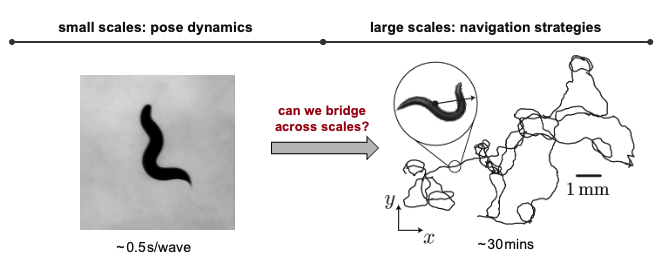

Let's first load the data

In [3]:
# worm centroids
f = h5py.File('./DPG_PhysicsBehavior_2026/data/worm_centroids.h5','r')
wormCM = ma.array(f['X_cm'])
wormCM[wormCM==0]=ma.masked
f.close()

#eigenworm time series
mat=h5py.File('./DPG_PhysicsBehavior_2026/data/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate
len_w,dim = tseries_w[0].shape

# mask first and last frame of each worm to not estimate transitions across
masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

tseries_all = ma.vstack(masked_ts_w)

#reconstructed body angles
eigenworms_matrix = np.loadtxt('./DPG_PhysicsBehavior_2026/data/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)

Let's plot an example of the worm's body curvature as a function of time (top), as well as the corresponding eigenworms coefficients (middle) and a full centroid trajectory (bottom).

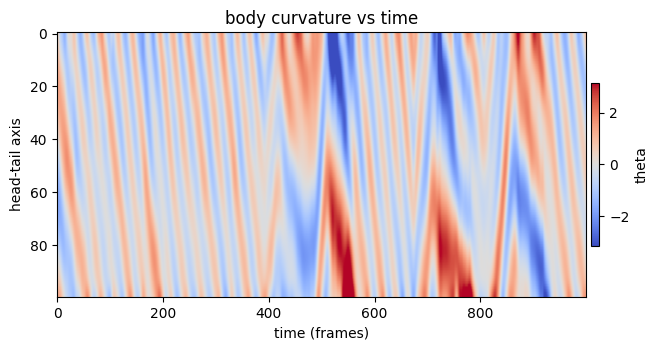

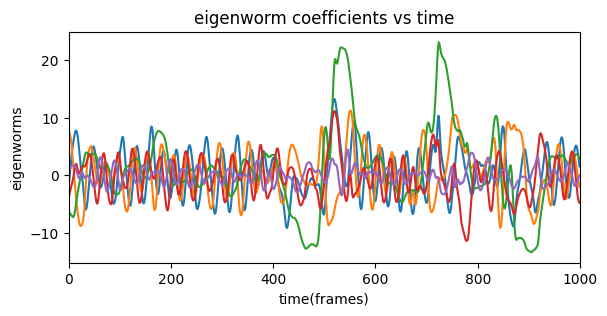

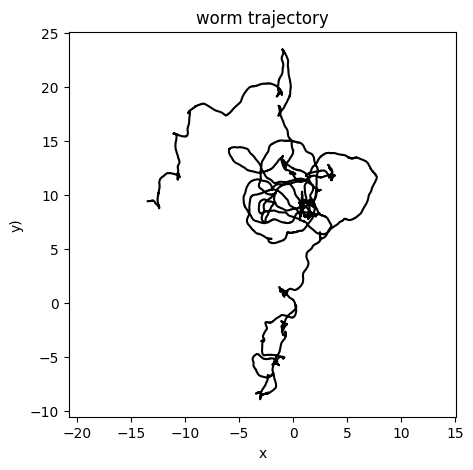

In [4]:
plt.figure(figsize=(7,5))
plt.title('body curvature vs time')
plt.imshow(thetas_w[9][1000:2000].T,aspect=5,cmap='coolwarm',vmin=-np.pi,vmax=np.pi)
plt.ylabel('head-tail axis')
plt.xlabel('time (frames)')
plt.colorbar(fraction=0.015, pad=0.01,label='theta')
plt.show()
plt.figure(figsize=(6.6,3))
plt.title('eigenworm coefficients vs time')
plt.plot(masked_ts_w[9][1000:2000])
plt.ylabel('eigenworms')
plt.xlabel('time(frames)')
plt.xlim(0,1000)
plt.show()
plt.figure(figsize=(5,5))
plt.title('worm trajectory')
plt.plot(wormCM[9][:,0],wormCM[9][:,1],c='k')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y)')
plt.show()

As you can see, the worms move by propagating waves along their body, which go from the head to the tail when it moves forward, and from tail to head when they move backwards. Additionally, they can turn both ventrally and dorsally with different magnitudes.

Each of these movements is $\sim 1\text{s}$ long, but we also see that the worm also engages in more macroscopic movement sequences. Let's reconstruct the transfer operator dynamics and see what we can learn from the eigenspectrum.

To that, as with the Lorenz system with partial observations, we first need to check if there's predictive information lying in past observations to reconstruct a maximally-predictive state space. Let's test that for an example worm (running the calculation over all worms is too slow for the tutorial)

In [5]:
from scipy.sparse import diags

example_tseries = masked_ts_w[0]

npartition_range=np.array(np.logspace(1,3.,4),dtype=int) #number of partitions to examine
range_Ks =  np.arange(1,15,1,dtype=int) #range of delays to study
h_K=np.zeros((len(range_Ks),len(npartition_range)))
Ipred_K=np.zeros((len(range_Ks),len(npartition_range)))
for k,K in enumerate(range_Ks):
    traj_matrix = embed.trajectory_matrix(example_tseries,K=K-1)
    print('created trajectory matrix of shape {}'.format(traj_matrix.shape))
    for kn,N in enumerate(npartition_range):
        labels=cl.kmeans_partition(traj_matrix,N,batchsize=5000)
        #estimate entropy rate
        P = op_calc.transition_matrix(labels,1)
        probs = op_calc.stationary_distribution(P)
        logP = P.copy()
        logP.data = np.log(logP.data)
        h = (-diags(probs).dot(P.multiply(logP))).sum()
        H = (-probs*np.log(probs)).sum()
        Ipred = H-h
        h_K[k,kn]=h
        Ipred_K[k,kn] = Ipred
        print('Computed for {} delays and {} partitions.'.format(K,N))

created trajectory matrix of shape (33600, 5)
Computed for 1 delays and 10 partitions.
Computed for 1 delays and 46 partitions.
Computed for 1 delays and 215 partitions.
Computed for 1 delays and 1000 partitions.
created trajectory matrix of shape (33600, 10)
Computed for 2 delays and 10 partitions.
Computed for 2 delays and 46 partitions.
Computed for 2 delays and 215 partitions.
Computed for 2 delays and 1000 partitions.
created trajectory matrix of shape (33600, 15)
Computed for 3 delays and 10 partitions.
Computed for 3 delays and 46 partitions.
Computed for 3 delays and 215 partitions.
Computed for 3 delays and 1000 partitions.
created trajectory matrix of shape (33600, 20)
Computed for 4 delays and 10 partitions.
Computed for 4 delays and 46 partitions.
Computed for 4 delays and 215 partitions.
Computed for 4 delays and 1000 partitions.
created trajectory matrix of shape (33600, 25)
Computed for 5 delays and 10 partitions.
Computed for 5 delays and 46 partitions.
Computed for 5 d

Let's now plot the entropy rate as a function of the number of partitions for varying K

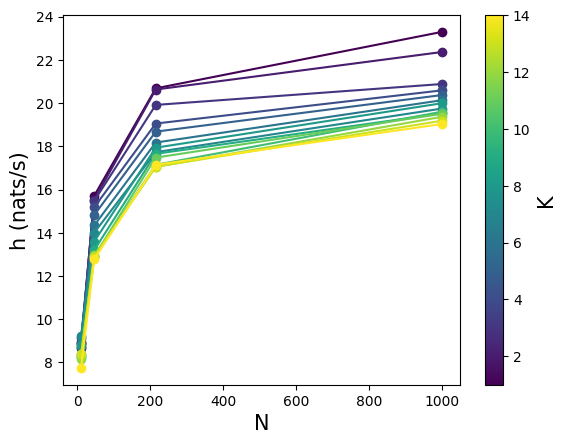

In [6]:
fig, ax = plt.subplots()

colors_K = plt.cm.viridis(np.linspace(0, 1, len(range_Ks)))
for k, K in enumerate(range_Ks):
    ax.plot(npartition_range, h_K[k]/dt, c=colors_K[k], marker='o', label=f'K={K}')

ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('h (nats/s)', fontsize=15)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(range_Ks), vmax=max(range_Ks)))
# sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('K', fontsize=15)

plt.show()

As you can see, the entropy rate curcevs start collapsing stops changing beyond $K\approx 6$ delays. Let's also check the results at $N=1000$ partitions.

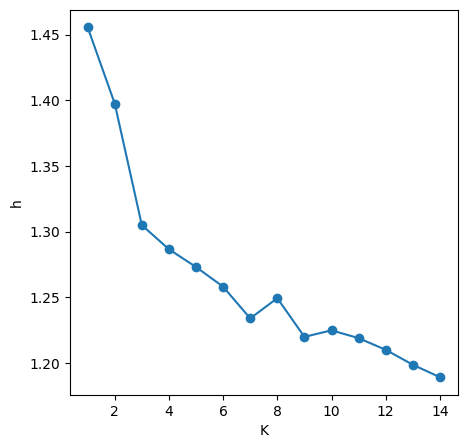

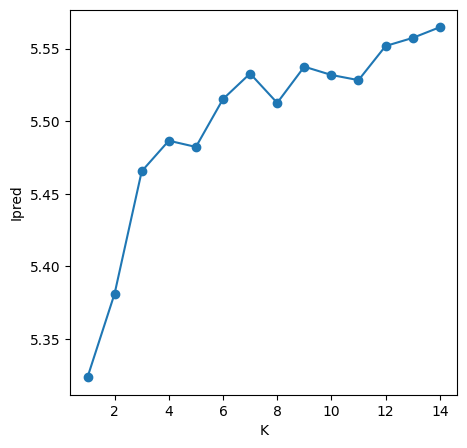

In [7]:
plt.figure(figsize=(5,5))
plt.plot(range_Ks,h_K[:,3],marker='o')
plt.xlabel('K')
plt.ylabel('h')
plt.show()
plt.figure(figsize=(5,5))
plt.plot(range_Ks,Ipred_K[:,3],marker='o')
plt.ylabel('Ipred')
plt.xlabel('K')
plt.show()

In [8]:
K_star=11
traj_matrix = embed.trajectory_matrix(tseries_all,K=K_star-1)

To gain intution over what the reconstructed state-space looks like, below we will plot a u-map embedding of the above trajectory matrix, which we directly load from a previous calculation to be faster. Each point corresponds to a sequence of $K^*=11$ postures. To interpret what the different regions of the state space correspond to, we color code the space by the body wave phase velocity (see Stephens et al. PLoS Comput Biol 2008) and the total curvature of the worm

In [9]:
n_neighbors=50;min_dist=.05
f = h5py.File('./DPG_PhysicsBehavior_2026/data/umap_n_{:.1f}_d_{:.2f}.h5'.format(n_neighbors,min_dist),'r')
u_all = ma.masked_invalid(f['umap'])
u_all[u_all==0] = ma.masked
f.close()
u = u_all[:-1000]

def unwrapma(x):
    idx= ma.array(np.arange(0,x.shape[0]),mask=x.mask)
    idxc=idx.compressed()
    xc=x.compressed()
    dd=np.diff(xc)
    ddmod=np.mod(dd+np.pi,2*np.pi)-np.pi
    ddmod[(ddmod==-np.pi)&(dd>0)]=np.pi
    phc_correct = ddmod-dd
    phc_correct[np.abs(dd)<np.pi] = 0
    ph_correct = np.zeros(x.shape)
    ph_correct[idxc[1:]] = phc_correct
    up = x + ph_correct.cumsum()
    return up

from scipy.interpolate import CubicSpline

def compute_omega(tseries,t0,tf,frameRate=16.):
    time=np.arange(t0,tf)
    X=tseries[time]
    phi=-np.arctan2(X[:,1],X[:,0])
    cs = CubicSpline(time, phi)
    phiFilt=cs(time)
    phi_unwrap=unwrapma(phi)
    sel=~phi_unwrap.mask
    cs = CubicSpline(time[sel], phi_unwrap[sel])
    phiFilt_unwrap=cs(time[sel])
    omegaFilt=cs(time[sel],1)*frameRate/(2*np.pi)
    return omegaFilt

segments=op_calc.segment_maskedArray(tseries_all,5)
omegas_all=ma.zeros(tseries_all.shape[0])
for t0,tf in segments:
    omegas_all[t0:tf] = compute_omega(tseries_all,t0,tf)
omegas_all[omegas_all==0]=ma.masked
thetas_sum = thetas_all.sum(axis=1)

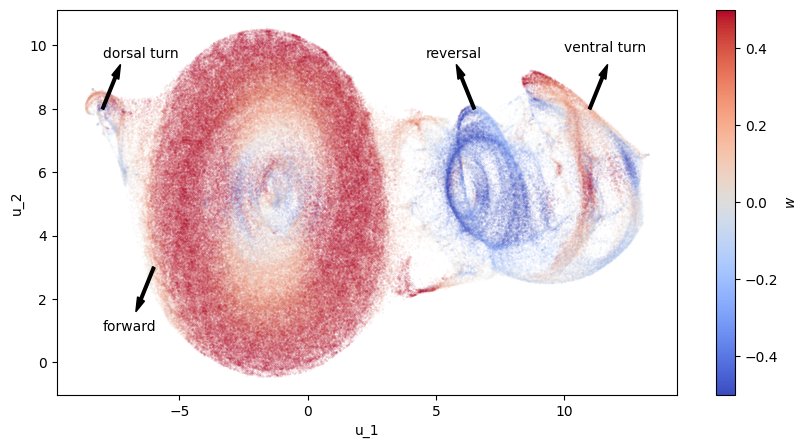

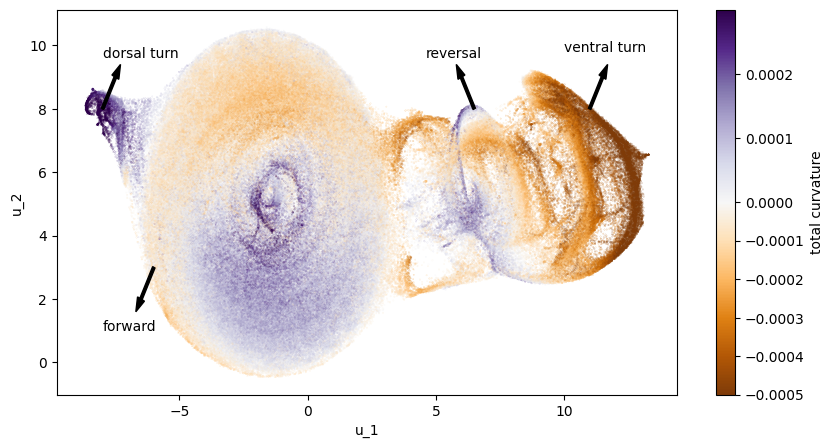

In [10]:
plt.figure(figsize=(10,5))
sel = ~omegas_all.mask
plt.scatter(u[sel,0],u[sel,1],c=omegas_all[sel],s=.001,cmap='coolwarm',vmax=.5,vmin=-.5)
plt.colorbar(label='$w$')
plt.xlabel('u_1')
plt.ylabel('u_2')
plt.arrow(-6,3,-.5,-1,width=.1,head_width=.3,color='k')
plt.text(-8,1,'forward')
plt.arrow(6.5,8,-.5,1,width=.1,head_width=.3,color='k')
plt.text(4.6,9.6,'reversal')
plt.arrow(11,8,.5,1,width=.1,head_width=.3,color='k')
plt.text(10,9.8,'ventral turn')
plt.arrow(-8,8,.5,1,width=.1,head_width=.3,color='k')
plt.text(-8,9.6,'dorsal turn')
plt.show()
from matplotlib.colors import TwoSlopeNorm
sel = ~thetas_sum.mask
vmin,vmax=-5e-4,3e-4
plt.figure(figsize=(10,5))
plt.scatter(u[sel,0],u[sel,1],s=.01,norm=TwoSlopeNorm(vcenter=0,vmin=vmin,vmax=vmax),c=thetas_sum[sel],cmap='PuOr')
plt.colorbar(label='total curvature')
plt.xlabel('u_1')
plt.ylabel('u_2')
plt.arrow(-6,3,-.5,-1,width=.1,head_width=.3,color='k')
plt.text(-8,1,'forward')
plt.arrow(6.5,8,-.5,1,width=.1,head_width=.3,color='k')
plt.text(4.6,9.6,'reversal')
plt.arrow(11,8,.5,1,width=.1,head_width=.3,color='k')
plt.text(10,9.8,'ventral turn')
plt.arrow(-8,8,.5,1,width=.1,head_width=.3,color='k')
plt.text(-8,9.6,'dorsal turn')
plt.show()

As you can see, different regions of the space correspond to different short-time movements of the worm. The big center cycle corresponds to forward waves (positive $\omega$), the smaller cycle in the center right to reversals (negative $\omega$), whereas the right and left lobes correspond to ventral and dorsal turns respectively.

Now that we have reconstructed the state space, let's use the Ulam-Galerkin method to approximate the transfer operator eigenvectors and see how these short time movements are combined over time

In [11]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(traj_matrix,N,batchsize=10000,return_centers=True)

In [12]:
delay=12 #more on delay selection in the Appendix
P_emp = op_calc.transition_matrix(labels_all,delay)
R = op_calc.get_reversible_transition_matrix(P_emp)
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=6)
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)

In [13]:
# for consistent color scheme when eigenvector flips
if eigvecs_emp[:,1].max()<-eigvecs_emp[:,1].min():
  color_map_phi2 = 'coolwarm'
else:
  color_map_phi2 = 'coolwarm_r'

Let's examine what the slowest mode, $\phi_2$ corresponds to, by color coding the posture state space by the projection along $\phi_2$.

In [14]:
phis_traj = ma.masked_invalid(eigvecs_emp[:,1:])[labels_all]
phis_traj[labels_all.mask]=ma.masked

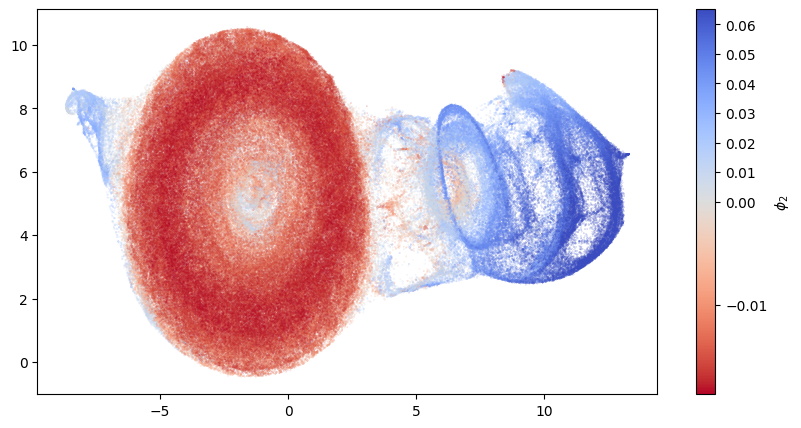

In [15]:
kd=0
sel = ~phis_traj[:,kd].mask
vmin,vmax=np.percentile(phis_traj[:,kd].compressed(),2.5),np.percentile(phis_traj[:,kd].compressed(),97.5)
plt.figure(figsize=(10,5))
plt.scatter(u[sel,0],u[sel,1],s=.01,norm=TwoSlopeNorm(vcenter=0,vmin=vmin,vmax=vmax),c=phis_traj[sel,kd],cmap=color_map_phi2)
plt.colorbar(label=r'$\phi_{}$'.format(kd+2))
plt.show()

The plot shows that $\phi_2$ essentially captures transitions between regions of the state space in which the worm linger in a forward run state, and regions in which in transitions between reversal and both dorsal and ventral turns. This combination of short-time behaviors has been coined a pirouette, and it is analogous to the tumbling of E. coli bacteria. To see that more clearly, we can color code the worm's centroid trajectory by $\phi_2$:

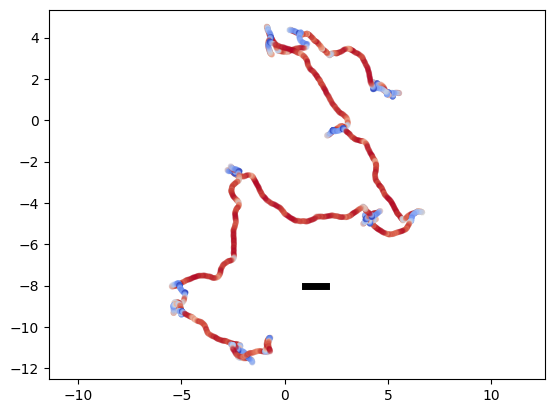

In [16]:
vmin,vmax=np.percentile(phis_traj[:,0].compressed(),2.5),np.percentile(phis_traj[:,0].compressed(),97.5)

len_w = len(tseries_w[0])
kw=8
t0 = int(5*frameRate*60)
tf=int(15*frameRate*60)
plt.scatter(wormCM[kw][t0:tf,0],wormCM[kw][t0:tf,1],c=phis_traj[kw*len_w:(kw+1)*len_w,0][t0:tf],s=10,alpha=.1,
            cmap=color_map_phi2,norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax))
plt.axis('equal')
plt.plot([1,2],[-8,-8],c='k',lw=5)
plt.show()

## Faster time scale modes

Besides the slowest mode of the dynamics, the remaining eigenvectors also capture important properties of behavior that evolve on increasingly faster timescales. To see that, let's look at some of the faster decaying modes

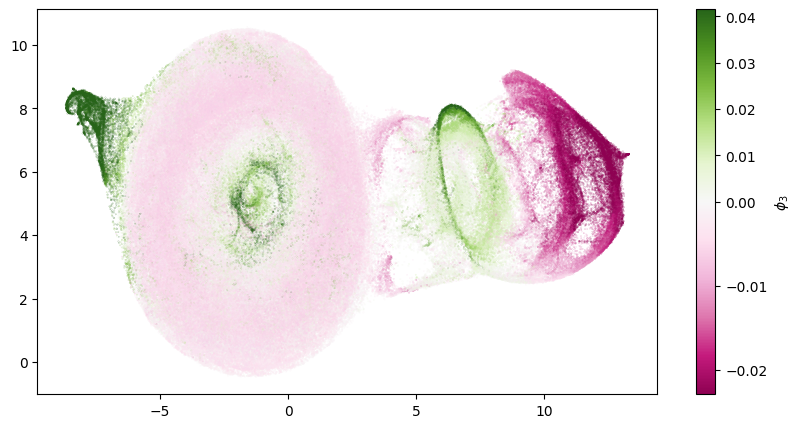

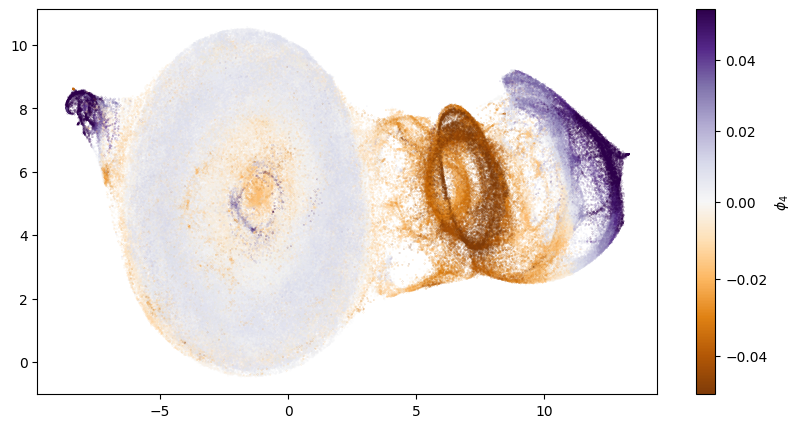

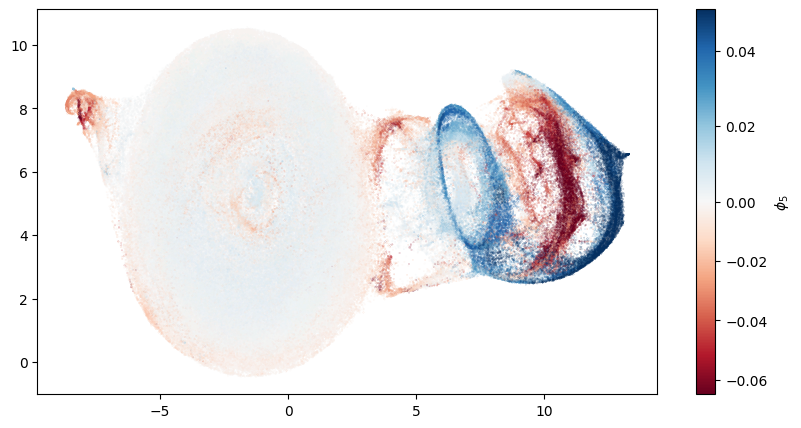

In [17]:
colormaps_phis = ['PiYG','PuOr','RdBu']
from matplotlib.colors import TwoSlopeNorm
for kd in range(1,4):
  sel = ~phis_traj[:,kd].mask
  vmin,vmax=np.percentile(phis_traj[:,kd].compressed(),2.5),np.percentile(phis_traj[:,kd].compressed(),97.5)
  plt.figure(figsize=(10,5))
  plt.scatter(u[sel,0],u[sel,1],s=.01,norm=TwoSlopeNorm(vcenter=0,vmin=vmin,vmax=vmax),c=phis_traj[sel,kd],cmap=colormaps_phis[kd-1])
  plt.colorbar(label=r'$\phi_{}$'.format(kd+2))
  plt.show()

As you can see, $\phi_3$ seems to correspond to a dorsal vs ventral bias during turns, $\phi_4$ splits reversals from ventral and dorsal turns, and $\phi_5$ distinguishes reversals followed by deep dorsal turns, from sequences of pauses, shallow ventral and dorsal turns.

# Appendix - $\tau$ selection

As before, we should examine the structure to the spectrum of the operator as a function of $\tau$ to avoid choosing a $\tau$ that is too large or too small.

In [18]:
n_worms = len(tseries_w)
labels_w =labels_all.reshape((n_worms,tseries_w[0].shape[0]))

In [19]:
delay_range = np.unique(np.array(np.logspace(0,2.5,30),dtype=int))
n_modes=8
tscales_delay = np.zeros((n_worms,len(delay_range),n_modes))
for kw in range(n_worms):
  for kd,delay in enumerate(delay_range):
    P_emp = op_calc.transition_matrix(labels_w[kw],delay)
    R = op_calc.get_reversible_transition_matrix(P_emp)
    eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=n_modes+1)
    timps=-delay*dt/np.log(eigvals_emp[1:].real)
    tscales_delay[kw,kd] = timps
  print(kw)

0
1
2
3
4
5
6
7
8
9
10
11


In [20]:
def bootstrap(l,n_times,confidence_interval=95):
  per=(100-confidence_interval)/2
  new_means=[]
  for i in range(n_times):
      indices=np.random.choice(range(0,len(l)),len(l))
      new_list=[l[idx] for idx in indices]
      new_means.append(ma.mean(new_list,axis=0))
  new_means=ma.vstack(new_means)
  cil=np.zeros(new_means.shape[1])
  ciu=np.zeros(new_means.shape[1])
  for i in range(new_means.shape[1]):
      cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
      ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
  cil = ma.masked_array(cil, np.isnan(cil))
  ciu = ma.masked_array(ciu, np.isnan(ciu))
  return ma.mean(l,axis=0),cil,ciu

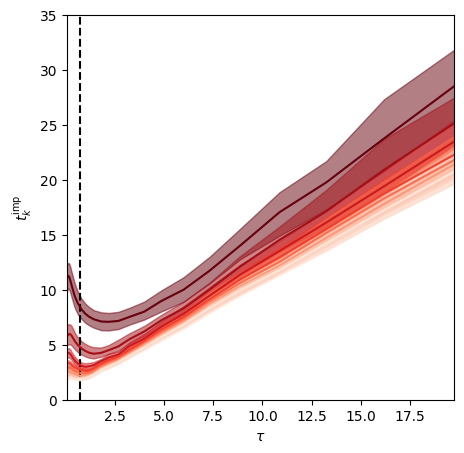

In [21]:
plt.figure(figsize=(5,5))
colors_ = plt.cm.Reds_r(np.linspace(0,.9,n_modes))
plt.axvline(0.75,c='k',ls='--',label=r'$\tau^*$')
for mode in range(n_modes):
    mean,cil,ciu=bootstrap(tscales_delay[:,:,mode],n_times=100)
    plt.plot(delay_range*dt,mean,c=colors_[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])
plt.xlim(delay_range[0]*dt,delay_range[-1]*dt)
plt.ylim(0,35)
plt.ylabel(r'$t^\text{imp}_k$')
plt.xlabel(r'$\tau$')
plt.show()

As you can see, beyond $\tau=0.75\text{s}$ the slowest implied timescale become approximately flat, before starting to grow linearly with $\tau$ signalling the $\tau→\infty$ limit.